In [1]:
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
def get_df(url):
    """Get data from URL."""
    response = requests.get(url)
    html_str = response.content.decode()

    # Parse HTML
    soup = BeautifulSoup(html_str, 'html.parser')
    rows = soup.find_all('tr')
    recipes = {}
    for row in rows:
        if row.td is None:  # skip header
            continue
        if row.td.string != 'success':  # skip non-successful recipes
            continue
        cols = row.find_all('td')
        recipe_name = cols[1].a.string
        date = pd.to_datetime(cols[2].string, format='%Y-%m-%d %H:%M:%S')
        runtime = pd.Timedelta(str(cols[3].string))

        # Only add recipe if it's more recent
        if recipe_name in recipes:
            if date < recipes[recipe_name]['date']:
                continue

        recipes[recipe_name] = {'date': date, 'runtime': runtime}

    df = pd.DataFrame.from_dict(recipes, orient='index')
    return df

In [3]:
url_v28 = 'https://esmvaltool.dkrz.de/shared/esmvaltool/v2.8.0/debug.html'
url_v211 = 'https://esmvaltool.dkrz.de/shared/esmvaltool/v2.11.0rc1/debug.html'

df_v28 = get_df(url_v28)
df_v211 = get_df(url_v211)
df = pd.merge(
    df_v28,
    df_v211,
    left_index=True,
    right_index=True,
    suffixes=['v2.8.0', 'v2.11.0'],
)
df = df.reset_index(names='recipe')
df
df = pd.wide_to_long(
    df,
    stubnames=['date', 'runtime'],
    i='recipe',
    j='version',
    suffix=r'v\d+\.\d+\.\d+',
)
df = df.reset_index()
df['runtime [s]'] = df['runtime'].dt.total_seconds()

runtimes_v28 = df.loc[df['version'] == 'v2.8.0', 'runtime [s]']
runtimes_v28.index = df.loc[df['version'] == 'v2.8.0', 'recipe']
runtimes_v211 = df.loc[df['version'] == 'v2.11.0', 'runtime [s]']
runtimes_v211.index = df.loc[df['version'] == 'v2.8.0', 'recipe']

comparison = pd.DataFrame.from_dict(
    {
        'diff': runtimes_v211 - runtimes_v28,
        'frac': runtimes_v211 / runtimes_v28,
    }
)
comparison

,diff,frac
recipe,,
recipe_albedolandcover,-14.0,0.500000
recipe_anav13jclim,-2544.0,0.223443
recipe_arctic_ocean,-1405.0,0.530257
recipe_autoassess_landsurface_permafrost,-4.0,0.851852
recipe_autoassess_landsurface_surfrad,0.0,1.000000
...,...,...
recipe_wenzel16jclim,-739.0,0.689626
recipe_wenzel16nat,-88.0,0.785366
recipe_wflow,-260.0,0.261364


In [4]:
comparison.describe()

,diff,frac
count,126.000000,126.000000
mean,100.968254,1.150654
std,2208.846196,2.382025
min,-4762.000000,0.041537
25%,-140.000000,0.527193
50%,-18.500000,0.750000
75%,-0.500000,0.995152
max,17108.000000,23.976190


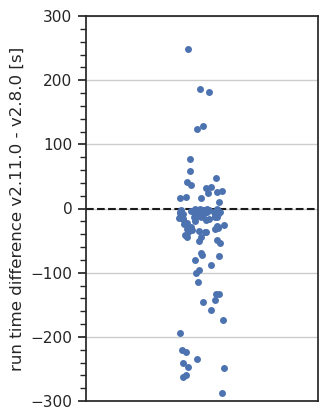

In [5]:
sns.set_theme(
    style='ticks',
    rc={
        'axes.grid': True,
        'figure.figsize':(3, 5),
        'xtick.bottom': False,
        'ytick.minor.visible': True,
    },
)

ax = sns.stripplot(comparison, y='diff')
ax.set_ylim([-300, 300])
ax.axhline(0, color='k', linestyle='--')
ax.set_ylabel('run time difference v2.11.0 - v2.8.0 [s]')
plt.savefig(
    'recipe_overview_diff.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)

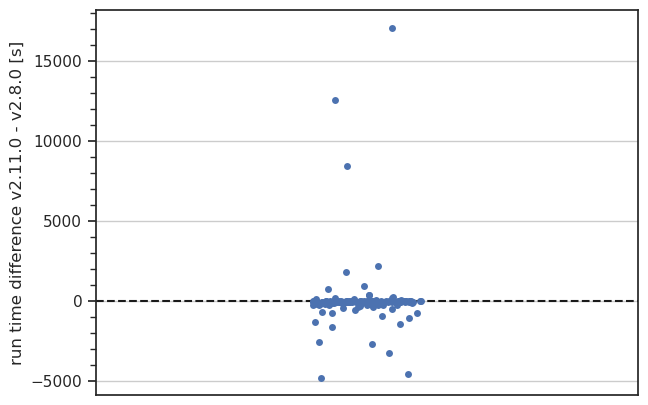

In [6]:
sns.set_theme(
    style='ticks',
    rc={
        'axes.grid': True,
        'figure.figsize':(7, 5),
        'xtick.bottom': False,
        'ytick.minor.visible': True,
    },
)

ax = sns.stripplot(comparison, y='diff')
ax.axhline(0, color='k', linestyle='--')
ax.set_ylabel('run time difference v2.11.0 - v2.8.0 [s]')
plt.savefig(
    'recipe_overview_diff_full.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)

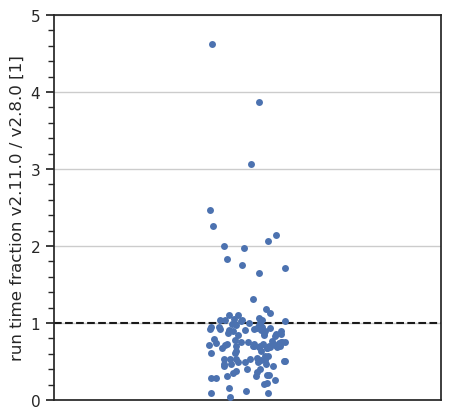

In [7]:
sns.set_theme(
    style='ticks',
    rc={
        'axes.grid': True,
        'figure.figsize':(5, 5),
        'xtick.bottom': False,
        'ytick.minor.visible': True,
    },
)

ax = sns.stripplot(comparison, y='frac')
ax.set_ylim([0, 5])
ax.axhline(1, color='k', linestyle='--')
ax.set_ylabel('run time fraction v2.11.0 / v2.8.0 [1]')
plt.savefig(
    'recipe_overview_frac.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)

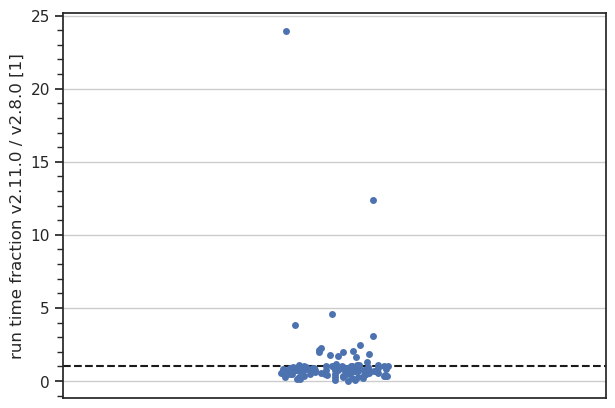

In [8]:
sns.set_theme(
    style='ticks',
    rc={
        'axes.grid': True,
        'figure.figsize':(7, 5),
        'xtick.bottom': False,
        'ytick.minor.visible': True,
    },
)

ax = sns.stripplot(comparison, y='frac')
ax.axhline(1, color='k', linestyle='--')
ax.set_ylabel('run time fraction v2.11.0 / v2.8.0 [1]')
plt.savefig(
    'recipe_overview_frac_full.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)